# Inside Company financials: Analytics and Prediction

## Table of contents
1. [Introduction](#intro)
2. [Data Preprocessing](#preprocess)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Deep EDA](#deda)
5. [Predictive Modeling and Forecasting](#predict)
6. [Ethical Considerations](#ethics)
7. [Conclusions](#conclude)
8. [References](#refer)

## 1. Introduction <a name="intro"></a>

In this project, I am going to analyse a dataset of the financial records of a company, covering their sales and profits over time. The data includes sales of multiple products, in multiple national markets, and with different levels of discounts applied to the sales, so there is plenty of scope here for analysis of how the data breaks down into different subcategories. Based on that, we can analyse how the company responds to different markets. We will compare sales and profits to investigate how a change in sales affects the company's overall profitability. The data on discounts applied to these sales also gives the opportunity to consider how sensitive the various markets represented here are to changes in price, and whether the company ought to increase its discounts to increase profits, or the reverse.

I will present the results of this investigation graphically, by tracking key metrics over time, and also by combining this dataset with a GeoPandas dataframe to allow visualisation of performance metrics in different regions.

The aim of the project is to develop a data-driven strategy for the company to improve its performance in the future, by fine-tuning its prices, and by exploring which market segments, and countries, are performing well, and which need additional attention. Thus, we can identify potential growth opportunities in specific markets.

My data comes from Kaggle [1], under the Database Contents License (DbCL) v1.0 [2].


## 2. Data Preprocessing <a name="preprocess"></a>

Below, I print a few rows of the dataset, to give an overview of what we can expect. We can see that the data will need some preprocessing before it is usable. Commas, hyphens and $ symbols will need to be stripped from the numerical fields, along with some improvement in the formatting. Then I will use the duplicated() method to check for any duplicated rows, and finally, I will look for any missing values in the data to be handled appropriately.



In [4]:
# Import the libraries I will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
#Load the financial dataset from csv file
financial_data = pd.read_csv('Financials.csv')

#Check the column names
print(financial_data.columns)

#Print a few rows
financial_data

Index(['Segment', 'Country', ' Product ', ' Discount Band ', ' Units Sold ',
       ' Manufacturing Price ', ' Sale Price ', ' Gross Sales ', ' Discounts ',
       '  Sales ', ' COGS ', ' Profit ', 'Date', 'Month Number',
       ' Month Name ', 'Year'],
      dtype='object')


Segment                   Country     Product   Discount Band   \
0          Government                    Canada   Carretera            None    
1          Government                   Germany   Carretera            None    
2           Midmarket                    France   Carretera            None    
3           Midmarket                   Germany   Carretera            None    
4           Midmarket                    Mexico   Carretera            None    
..                ...                       ...          ...             ...   
695    Small Business                    France    Amarilla            High    
696    Small Business                    Mexico    Amarilla            High    
697        Government                    Mexico     Montana            High    
698        Government                    Canada       Paseo            High    
699  Channel Partners  United States of America         VTT            High    

     Units Sold   Manufacturing Price   Sale Price     Gross Sales   \
0     $1,618.50                 $3.00       $20.00      $32,370.00    
1     $1,321.00                 $3.00       $20.00      $26,420.00    
2     $2,178.00                 $3.00       $15.00      $32,670.00    
3       $888.00                 $3.00       $15.00      $13,320.00    
4     $2,470.00                 $3.00       $15.00      $37,050.00    
..           ...                   ...          ...             ...   
695   $2,475.00               $260.00      $300.00    $7,42,500.00    
696     $546.00               $260.00      $300.00    $1,63,800.00    
697   $1,368.00                 $5.00        $7.00       $9,576.00    
698     $723.00                $10.00        $7.00       $5,061.00    
699   $1,806.00               $250.00       $12.00      $21,672.00    

         Discounts           Sales            COGS        Profit         Date  \
0             $-        $32,370.00      $16,185.00    $16,185.00   01/01/2014   
1             $-        $26,420.00      $13,210.00    $13,210.00   01/01/2014   
2             $-        $32,670.00      $21,780.00    $10,890.00   01/06/2014   
3             $-        $13,320.00       $8,880.00     $4,440.00   01/06/2014   
4             $-        $37,050.00      $24,700.00    $12,350.00   01/06/2014   
..              ...             ...             ...           ...         ...   
695   $1,11,375.00    $6,31,125.00    $6,18,750.00    $12,375.00   01/03/2014   
696     $24,570.00    $1,39,230.00    $1,36,500.00     $2,730.00   01/10/2014   
697      $1,436.40       $8,139.60       $6,840.00     $1,299.60   01/02/2014   
698        $759.15       $4,301.85       $3,615.00       $686.85   01/04/2014   
699      $3,250.80      $18,421.20       $5,418.00    $13,003.20   01/05/2014   

     Month Number  Month Name   Year  
0               1     January   2014  
1               1     January   2014  
2               6        June   2014  
3               6        June   2014  
4               6        June   2014  
..            ...          ...   ...  
695             3       March   2014  
696            10     October   2014  
697             2    February   2014  
698             4       April   2014  
699             5         May   2014  

[700 rows x 16 columns]

Looking at the data, we see that some columns names end in unnecessary spaces (for example, 'Product '). I will remove such spaces from column names.

In [6]:
# Remove extra spaces from column names
financial_data.columns = financial_data.columns.str.strip()

# Print the column names to check they are now correct
print(financial_data.columns)

Index(['Segment', 'Country', 'Product', 'Discount Band', 'Units Sold',
       'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts',
       'Sales', 'COGS', 'Profit', 'Date', 'Month Number', 'Month Name',
       'Year'],
      dtype='object')


In [7]:
print(sum(financial_data.duplicated()))

0


Now the column names are ok, and we know there are no duplicated rows, I will remove '$', '-' and ',' from columns containing numerical data and convert columns to appropriate numeric data types.

For columns containing strings as data, I will strip unnecessary spaces from the values.

In [8]:
# Convert 'Date' column to datetime
financial_data['Date'] = pd.to_datetime(financial_data['Date'],dayfirst=True)

# Clean numeric columns
numeric_cols = ['Units Sold', 'Manufacturing Price', 'Sale Price', 'Gross Sales', 'Discounts', 'Sales', 'COGS', 'Profit']

for col in numeric_cols:
    financial_data[col] = financial_data[col].replace({'\$': '', '-': '', ',': ''}, regex=True)

financial_data[numeric_cols] = financial_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Clean string columns
str_cols = ['Segment', 'Country', 'Product', 'Discount Band', 'Month Name']

for col in str_cols:
  financial_data[col]=financial_data[col].str.strip()

# Display the first few rows of the preprocessed dataset
print(financial_data.head())

      Segment  Country    Product Discount Band  Units Sold  \
0  Government   Canada  Carretera          None      1618.5   
1  Government  Germany  Carretera          None      1321.0   
2   Midmarket   France  Carretera          None      2178.0   
3   Midmarket  Germany  Carretera          None       888.0   
4   Midmarket   Mexico  Carretera          None      2470.0   

   Manufacturing Price  Sale Price  Gross Sales  Discounts    Sales     COGS  \
0                  3.0        20.0      32370.0        NaN  32370.0  16185.0   
1                  3.0        20.0      26420.0        NaN  26420.0  13210.0   
2                  3.0        15.0      32670.0        NaN  32670.0  21780.0   
3                  3.0        15.0      13320.0        NaN  13320.0   8880.0   
4                  3.0        15.0      37050.0        NaN  37050.0  24700.0   

    Profit       Date  Month Number Month Name  Year  
0  16185.0 2014-01-01             1    January  2014  
1  13210.0 2014-01-01         

I have converted all these numeric columns to floats &ndash; even though some, like Units Sold, may seem like they should take integer values &ndash; after noting that in the first row of the database, Units Sold is 1618.5.

It is import to check whether you have any missing values or not before you do any exploration or train it. i'll use isnull().sum()) to check for missing values.

In [9]:
# Check for missing values
print(financial_data.isnull().sum())

Segment                 0
Country                 0
Product                 0
Discount Band           0
Units Sold              0
Manufacturing Price     0
Sale Price              0
Gross Sales             0
Discounts              53
Sales                   0
COGS                    0
Profit                 63
Date                    0
Month Number            0
Month Name              0
Year                    0
dtype: int64


As we know that there are some missing values from the Profit column and the Discounts column, I print out the rows with a value missing for each of these columns to see how best to handle them.

In [10]:
print(financial_data[financial_data['Profit'].isnull()])
print(financial_data[financial_data['Discounts'].isnull()])

        Segment                   Country   Product Discount Band  Units Sold  \
187  Enterprise                    Mexico   Montana           Low      1138.0   
189  Enterprise                   Germany     Paseo           Low       795.0   
193  Enterprise                    France     Paseo           Low      2988.0   
200  Enterprise                    Mexico     Paseo           Low      1138.0   
209  Enterprise                    Mexico  Amarilla           Low      1074.0   
..          ...                       ...       ...           ...         ...   
676  Enterprise                   Germany     Paseo          High      1085.0   
684  Enterprise                    France      Velo          High       663.0   
686  Enterprise  United States of America      Velo          High      2438.0   
692  Enterprise                    Canada       VTT          High      2954.0   
693  Enterprise                   Germany       VTT          High       552.0   

     Manufacturing Price  S

Inspecting these rows, a pattern becomes apparent: the null values occur where the entry ought to be zero or negative. Examining the printed rows of the unpreprocessed database above, we can see that such cases are stored in the original database as '$-', instead of with their numerical value. Therefore, I will fill in these entries with the correctly calculated values.

The column names suggest the equations $$\text{Profit} = \text{Sales} - \text{COGS}$$ and $$\text{Discounts} = \text{Gross Sales} - \text{Sales};$$ it is easy to check that these equations hold for the non-null entries in the database. I include below the verification for Profit, but Discounts can be handled in the same way. Finally, I replace the null values with the calculated ones.

In [11]:
# Calculate the expected profit for each row
financial_data['Expected Profit'] = financial_data['Sales'] - financial_data['COGS']

# Check for discrepancies between the calculated expected profit and the existing profit values
discrepancies = financial_data[financial_data['Profit'] - financial_data['Expected Profit'] >= 0.01]

# Display rows with discrepancies
print(discrepancies)

# Remove the 'Expected Profit' column from the DataFrame
financial_data.drop('Expected Profit', axis=1, inplace=True)


Empty DataFrame
Columns: [Segment, Country, Product, Discount Band, Units Sold, Manufacturing Price, Sale Price, Gross Sales, Discounts, Sales, COGS, Profit, Date, Month Number, Month Name, Year, Expected Profit]
Index: []


This shows my inference of the calculation of Profit was correct. I have ignored discrepancies less than 0.01 here, since these are just rounding errors caused by floating-point arithmetic.

Repeating the analogous calculation for Discounts gives the same result.

In [12]:
# Calculate Profit as Sales - COGS for rows where Profit is NaN
financial_data['Profit'] = financial_data.apply(
    lambda row: row['Sales'] - row['COGS'] if pd.isnull(row['Profit']) else row['Profit'],
    axis=1
)
print(len(financial_data[financial_data['Profit'].isnull()]))

# Calculate Discounts as Gross Sales - Sales for rows where Discounts is NaN
financial_data['Discounts'] = financial_data.apply(
    lambda row: row['Gross Sales'] - row['Sales'] if pd.isnull(row['Discounts']) else row['Discounts'],
    axis=1
)
print(len(financial_data[financial_data['Discounts'].isnull()]))

# All zeros below indicates there are no more missing values

0
0


In [13]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Segment              700 non-null    object        
 1   Country              700 non-null    object        
 2   Product              700 non-null    object        
 3   Discount Band        700 non-null    object        
 4   Units Sold           700 non-null    float64       
 5   Manufacturing Price  700 non-null    float64       
 6   Sale Price           700 non-null    float64       
 7   Gross Sales          700 non-null    float64       
 8   Discounts            700 non-null    float64       
 9   Sales                700 non-null    float64       
 10  COGS                 700 non-null    float64       
 11  Profit               700 non-null    float64       
 12  Date                 700 non-null    datetime64[ns]
 13  Month Number         700 non-null  

## 3. Exploratory Data Analysis (EDA) <a name="eda"></a>

Now my dataset is well-structured for a wide range of data analysis tasks, including statistical analysis, visualizations, and time series forecasting. First, I will have a look at a statistical summary for the numerical columns to get a sense of distribution, mean, median, etc.

In [14]:
financial_data[numeric_cols].describe()

Units Sold  Manufacturing Price  Sale Price   Gross Sales  \
count   700.000000           700.000000  700.000000  7.000000e+02   
mean   1608.294286            96.477143  118.428571  1.827594e+05   
std     867.427859           108.602612  136.775515  2.542623e+05   
min     200.000000             3.000000    7.000000  1.799000e+03   
25%     905.000000             5.000000   12.000000  1.739175e+04   
50%    1542.500000            10.000000   20.000000  3.798000e+04   
75%    2229.125000           250.000000  300.000000  2.790250e+05   
max    4492.500000           260.000000  350.000000  1.207500e+06   

           Discounts         Sales           COGS         Profit  
count     700.000000  7.000000e+02     700.000000     700.000000  
mean    13150.354671  1.696091e+05  145475.211429   24133.860414  
std     22962.928760  2.367263e+05  203865.506118   42760.626547  
min         0.000000  1.655080e+03     918.000000  -40617.500000  
25%       800.320000  1.592800e+04    7490.000000    2805.960000  
50%      2585.250000  3.554020e+04   22506.250000    9242.200000  
75%     15956.347500  2.610775e+05  245607.500000   22662.000000  
max    149677.500000  1.159200e+06  950625.000000  262200.000000

My first impression is many of the columns show heavily right-skewed distributions: in fact, for all but Units Sold, the mean is several times larger than the median, and the standard deviation is larger still: for all these cases, 0 is within one standard deviation of the mean.

This means that a comparatively small number of transactions constitutes most of the business of this company, and that the distribution of transaction sizes is far from normal; domain knowledge suggests a power law distribution might be a better fit.

## 3.1 Which segment generates the highest revenue and maintains the most favourable profit margins?

To answer this question, I will present a few graphs. First of all, I will group the dataset by the 'Segment' column. Each unique value in the 'Segment' column creates a group. For each group created, I calculate the total sales, total profit, and total units sold for each segment, then plot it to see how the segments compare.

            Segment  Total sales  Total profit  Total units sold
0  Channel Partners   1800593.64    1316803.14          161263.5
1        Enterprise  19611694.38    -614545.62          168552.0
2        Government  52504260.68   11388173.18          470673.5
3         Midmarket   2381883.09     660103.09          172178.0
4    Small Business  42427918.50    4143168.50          153139.0


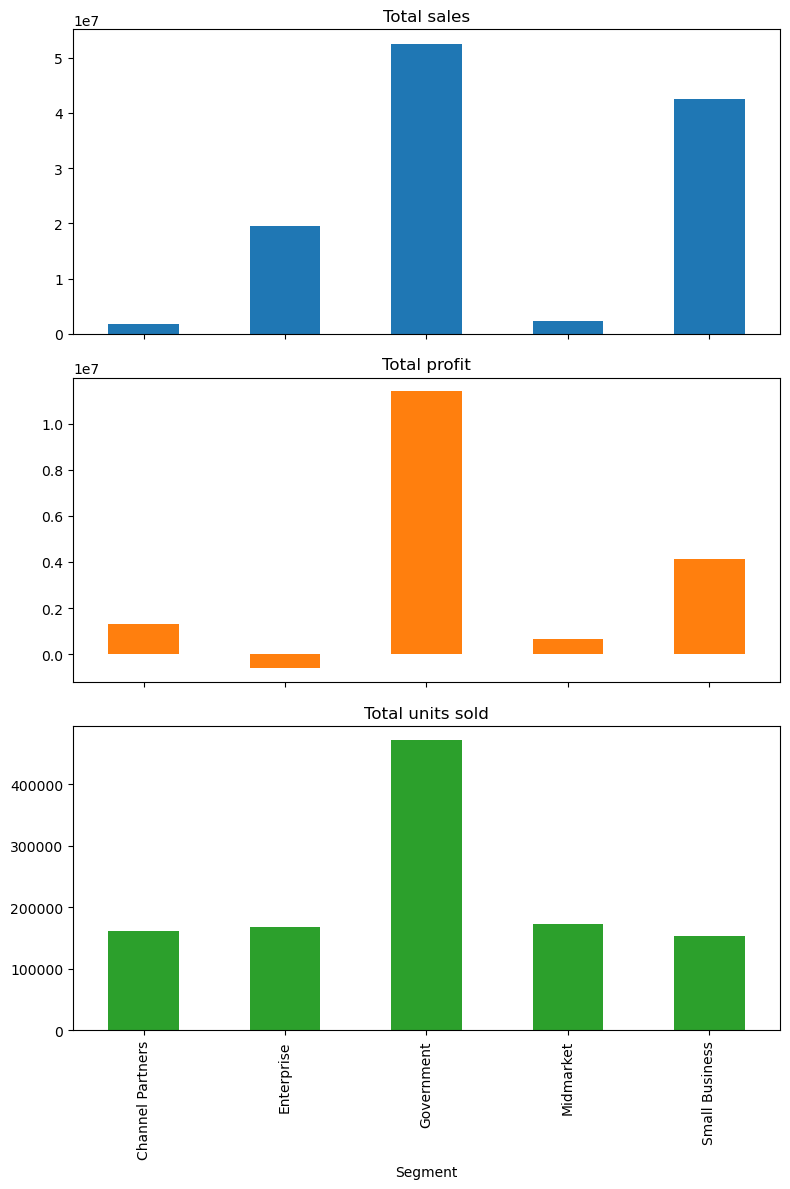

In [15]:
# Segment Performance
segment_performance = financial_data.groupby('Segment').agg({'Sales': 'sum', 'Profit': 'sum', 'Units Sold': 'sum'}).reset_index()
segment_performance.rename(columns = {'Sales':'Total sales',
                                              'Profit':'Total profit',
                                              'Units Sold':'Total units sold'}, inplace=True)
print(segment_performance)

# Plot total sales, profit, and units sold by segment
segment_performance.plot(x='Segment', kind='bar', subplots=True, layout=(3,1), figsize=(8, 12), legend=False)
plt.tight_layout()
plt.show()


We can see the Government segment has the highest contribution to Sales, Profit and Units Sold, with Small Business making up most of the rest of the Profit despite its unremarkable Units Sold. Perhaps small businesses' weaker bargaining position allows this company to charge them higher prices. Remarkably, despite healthy levels of Sales and Units Sold, the Enterprise segment makes a net loss of $610,000. The company ought to examine the pricing levels it charges in this segment, as such losses may be unsustainable over the long term.

To look further into how the data looks per segment, I want to calculate some more summary statistics. I organise the data by Segment using the groupby method, as before. Next, I apply the agg method, which allows me to specify multiple statistical functions &ndash; mean, median, and standard deviation &ndash; for each of the columns: Sales, Profit, and Units Sold. This provides a comprehensive view of performance metrics across different segments, showing not just average performance but also the variability and typical values for each segment. Finally, I plot these to get a clear overview.

In [16]:
# Calculate summary statistics for sales and profit for each market segment
summary_stats = financial_data.groupby('Segment').agg({
    'Sales': ['count','mean', 'median', 'std'],
    'Profit': ['mean', 'median', 'std'],
    'Units Sold': ['mean', 'median', 'std']
})
print("Summary Statistics for Sales and Profit by Market Segment:")
summary_stats

Summary Statistics for Sales and Profit by Market Segment:


Sales                                            \
                 count           mean      median            std   
Segment                                                            
Channel Partners   100   18005.936400   18498.960    9156.473502   
Enterprise         100  196116.943800  185389.375  107631.255803   
Government         300  175014.202267   27286.875  266986.546682   
Midmarket          100   23818.830900   24349.650   12324.443638   
Small Business     100  424279.185000  373755.000  239938.999668   

                        Profit                            Units Sold          \
                          mean     median           std         mean  median   
Segment                                                                        
Channel Partners  13168.031400  13242.960   6706.583019  1612.635000  1657.0   
Enterprise        -6145.456200  -2769.375  11871.787155  1685.520000  1589.5   
Government        37960.577267  12360.800  56108.500054  1568.911667  1494.5   
Midmarket          6601.030900   6665.800   3555.430312  1721.780000  1818.5   
Small Business    41431.685000  36592.500  31045.668904  1531.390000  1369.0   

                              
                         std  
Segment                       
Channel Partners  823.497260  
Enterprise        919.606484  
Government        853.485276  
Midmarket         896.248490  
Small Business    869.356617

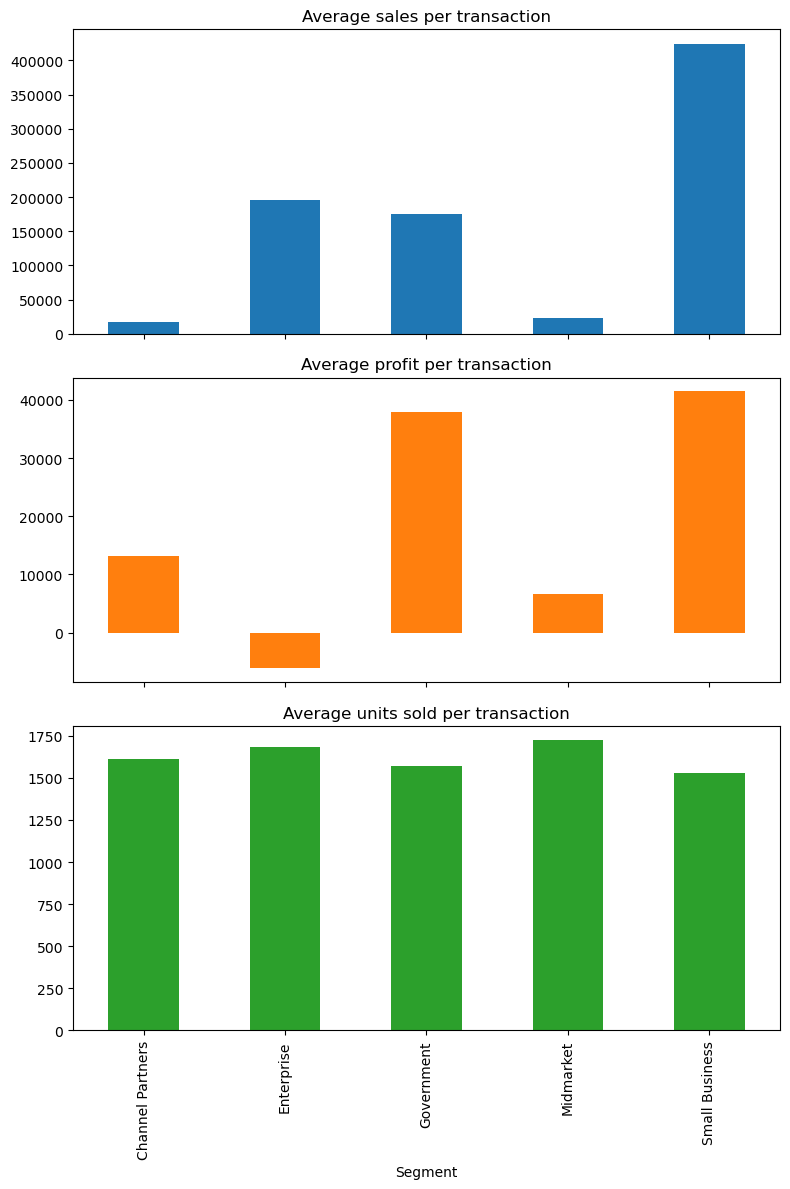

In [17]:
average_segment_performance = financial_data.groupby('Segment').agg({'Sales': 'mean', 'Profit': 'mean', 'Units Sold': 'mean'}).reset_index()
average_segment_performance.rename(columns = {'Sales':'Average sales per transaction',
                                              'Profit':'Average profit per transaction',
                                              'Units Sold':'Average units sold per transaction'}, inplace=True)

# Plot average sales, profit, and units sold by segment per transaction
average_segment_performance.plot(x='Segment', kind='bar', subplots=True, layout=(3,1), figsize=(8, 12), legend=False)
plt.tight_layout()
plt.show()


It is immediately noticeable that, in contrast to the summary statistics for the whole dataset, the distributions of Sales and Profit for the Channel Partners, Enterprise, Midmarket and Small Business segments are no longer clearly right-skewed. For all these cases, the mean and median are very similar. On the other hand, the distributions for Government still show the right-skewed behaviour: for example, the mean Government sale is \$175,000, while the median is only \$27,000. So amongst Government sales, the distribution is still dominated by the largest entries.

We now look more closely, to provide valuable insights into the performance across different segments of the market.

**Channel Partners**

In total, Sales with Channel Partners are small, even though total Units Sold is comparable to the other non-Government segments. Profits are somewhat better. This suggests that transactions in this segment might involve lower prices, but that this is justified in the light of lower costs associated with doing business in this segment.

**Enterprise**


The average Sales is high but has a large standard deviation, suggesting significant variability in the size of deals within this segment. The mean and median in the profit of this segment is negative, indicating overall losses. The negative median profit and high standard deviation reveal that not only is the segment unprofitable on average, but there's also considerable inconsistency in profitability. Despite the losses, the mean and median units sold are relatively high, suggesting that while the segment moves a good volume of units, it's not translating into profitability. Here, the company should look beyond this database, to try and understand what makes some transactions so much more profitable than others.

**Government**

For this segment, Sales have a high average but an extremely high standard deviation and a low median compared to the mean, indicating a highly variable segment with some extremely large transactions alongside many smaller ones.
Profit similarly shows a wide variance, with the mean significantly higher than the median. As noted above, this shows that, within the Government segment, the distribution is still heavily right-skewed. The Government segment is by far the largest in total Sales and total Units Sold, but most of all in total Profit. It also performs near the top in average Profit per transaction. Overall, this means that any expansion of the segment is likely to be extremely favourable to the company, and should be strongly encouraged. One point to keep in mind, though, is that the small number of extremely large transactions here could lead to less predictability over time, as governmental priorities change. Ideally, these large deals should be assured by long-term contracts to guarantee future income.

**Midmarket**

This is one of the smallest segments in terms of total Sales and total Profit. The average profit per transaction is the second-lowest too, after Enterprise. The total Units Sold is comparable to other non-Government segments, with a modest standard deviation, suggesting consistent performance in volume, but this does not translate into large profits.

**Small Business**

Interestingly, Sales and Profit both have the highest means among all segments, indicating that this segment likely contains the most favourable transactions on average. The standard deviation for sales and profit (relative to the mean) is similar to the other non-Government segments. Despite its better average, the Small Business segment has lower total Sales and Profit than Government due to its smaller size, but any potential for expansion here should be aggressively explored, as growth could replace the more anemic Enterprise and Midmarket segments while avoiding the risks of relying too much on the few large transactions from Government.


To support this analysis, I will conduct statistical tests to answer the following two questions: is the difference in profit per transaction significant between Small Business and (a) Government; (b) all other segments?

To answer these questions, I conduct a two-sample independent t-test comparing profit between the two market segments.





In [18]:
# Segments to test
segment1 = 'Small Business'
segment2 = 'Government'

# Get the profit data for these segments
profit_segment1 = financial_data.loc[financial_data['Segment'] == segment1, 'Profit']
profit_segment2 = financial_data.loc[financial_data['Segment'] == segment2, 'Profit']
profit_other = financial_data.loc[~financial_data['Segment'].isin([segment1, segment2]), 'Profit']

# Perform t-test for profit between the two market segments
t_stat_profit, p_value_profit = ttest_ind(profit_segment1, profit_segment2, equal_var=False)
print(f"T-Test for Profit between {segment1} and {segment2}:")
print("T-Statistic:", t_stat_profit)
print("P-Value:", p_value_profit)

# T-test for profit between Small Business and others
t_stat_profit, p_value_profit = ttest_ind(profit_segment1, profit_other, equal_var=False)
print(f"T-Test for Profit between {segment1} and others:")
print("T-Statistic:", t_stat_profit)
print("P-Value:", p_value_profit)

T-Test for Profit between Small Business and Government:
T-Statistic: 0.773610427586127
P-Value: 0.4397503763802525
T-Test for Profit between Small Business and others:
T-Statistic: 11.623736782886377
P-Value: 9.493196555576762e-21


We immediately see from the p-values that there is no significant difference in average profits between Small Business and Government (p=0.44), but that the difference with other segments is highly significant (p<$10^{-20}$). In analysing the differences between the profitability of segments, it will often make sense to think of the Small Business and Government segments together, as a much more profitable part of the company than the others. This suggests targeted strategies towards the Small Business and Government segments could be particularly beneficial for enhancing overall profitability.

### Given that our data indicate higher total Sales and Profit within the Government segment but higher average Sales and Profit margins within the Small Business segment, how can we understand and explain the reasons behind this discrepancy in performance between these two segments?

Looking at the number of transactions and average sales per transaction for each of these segments, we can draw several conclusions about the sales dynamics and strategic implications for each segment.

Government: With the highest number of transactions (300) and high average sales per transaction ($175,000), the Government segment appears to be both active and lucrative. This could be due to large government contracts and consistent demand for products or services, possibly with long-term agreements that ensure a steady flow of high-value transactions.

Small Business: With 100 transactions and the highest average sales per transaction by a long way ($424,000), the Small Business segment presents a unique case of fewer, yet significantly larger deals on average. This could indicate that while the segment may not have the volume of the Government segment, it compensates with substantial transaction values, possibly due to solutions tailored to the needs of individual small businesses.

So maybe the sale price is the factor here:

            Segment  Sale Price
0  Channel Partners   12.000000
1        Enterprise  125.000000
2        Government  125.666667
3         Midmarket   15.000000
4    Small Business  300.000000


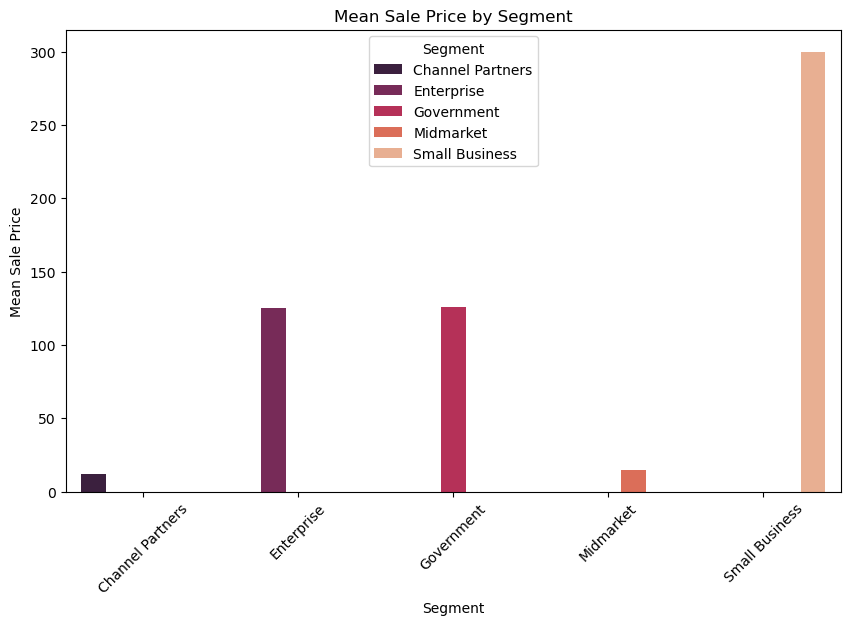

In [19]:
# Calculate the mean sale price by segment
mean_sale_price_by_segment = financial_data.groupby('Segment')['Sale Price'].mean().reset_index()

print(mean_sale_price_by_segment)

# Plotting the mean sale price by segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Sale Price', data=mean_sale_price_by_segment, palette='rocket', hue='Segment')
plt.title('Mean Sale Price by Segment')
plt.xlabel('Segment')
plt.ylabel('Mean Sale Price')
plt.xticks(rotation=45)
plt.show()

So I can see here the sale price is the main factor that makes the average Sales of Small Business higher than Government. There are a few guesses I can suggest here to explain why the sale price in Small Business could be so much higher:

1. Pricing Strategy and Volume: With the Government, sales might be priced more competitively due to the nature of the public procurement process. The products sold to Small Businesses could be more specialised or customised, justifying the higher price point.

2. Nature of Purchases: Government purchases often include bulk buying, which can further reduce the average price per unit due to volume discounts. The scale of government operations and the need for large quantities of goods and services can contribute to a larger total sales volume, even if the price per unit is lower. Small Businesses may make purchases that are critical for their operations or growth, leading to less price sensitivity for specific high-value items or services. This results in a higher average sale price, and a lower sales volume than in the Government segment.


### Strategic Insights:

Focus on Small Business: Given its high revenue and profit potential, focusing on the Small Business segment could yield significant returns. However, companies should be prepared for the variability inherent in this segment.

Enterprise Strategy: For the Enterprise segment, strategies could involve increasing the profitability of deals, given that it has high sales volume but lower average profits.

Government Opportunities: The high variability in the Government segment's sales and profit suggests that while it includes some very lucrative deals, it may require a tailored approach to capture these opportunities effectively. These large deals should be subject to long-term contract as far as possible, even if this comes with a trade-off in sale price.

Stable Growth Areas: The Midmarket and Channel Partners segments offer more predictable, consistent returns, which could be valuable for steady growth and risk management.

Overall, each segment presents unique opportunities and challenges. A balanced strategy that leverages the strengths of each segment while mitigating risks and variability can help in maximizing overall sales and profit over the long term.

## 3.2 Which products have the highest sales and profit?

To find out which product has the highest sales and profit, I group the data by 'Product' and then aggregate the 'Sales' and 'Profit'. After that, I identify the product with the highest total sales and the product with the highest total profit.

     Product        Sales      Profit
0   Amarilla  17747116.07  2814104.07
1  Carretera  13815307.89  1826804.89
2    Montana  15390801.88  2114754.88
3      Paseo  33011143.96  4797437.96
4        VTT  20511921.02  3034608.02
5       Velo  18250059.47  2305992.47

Product with the highest sales:
Product          Paseo
Sales      33011143.96
Profit      4797437.96
Name: 3, dtype: object

Product with the highest profit:
Product          Paseo
Sales      33011143.96
Profit      4797437.96
Name: 3, dtype: object


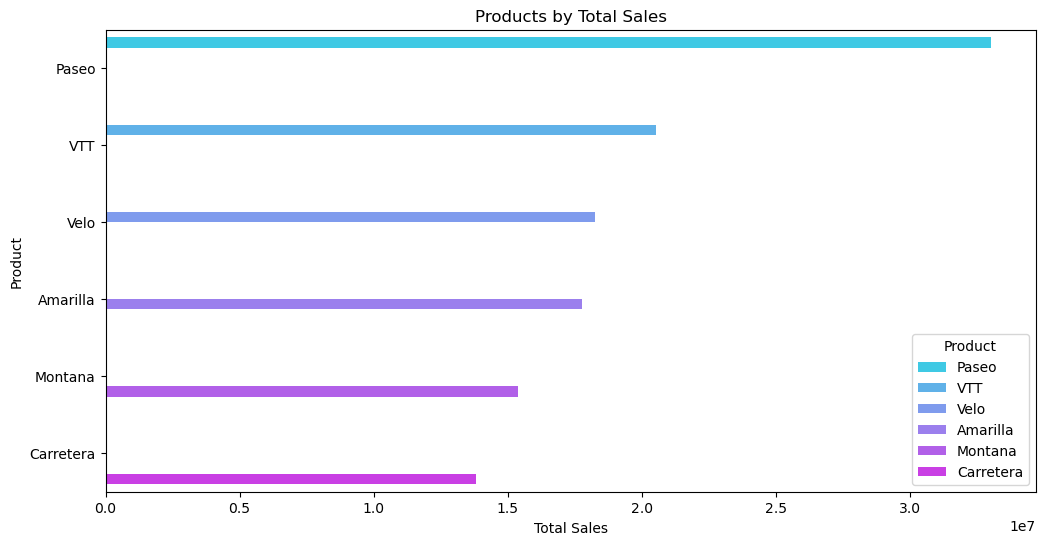

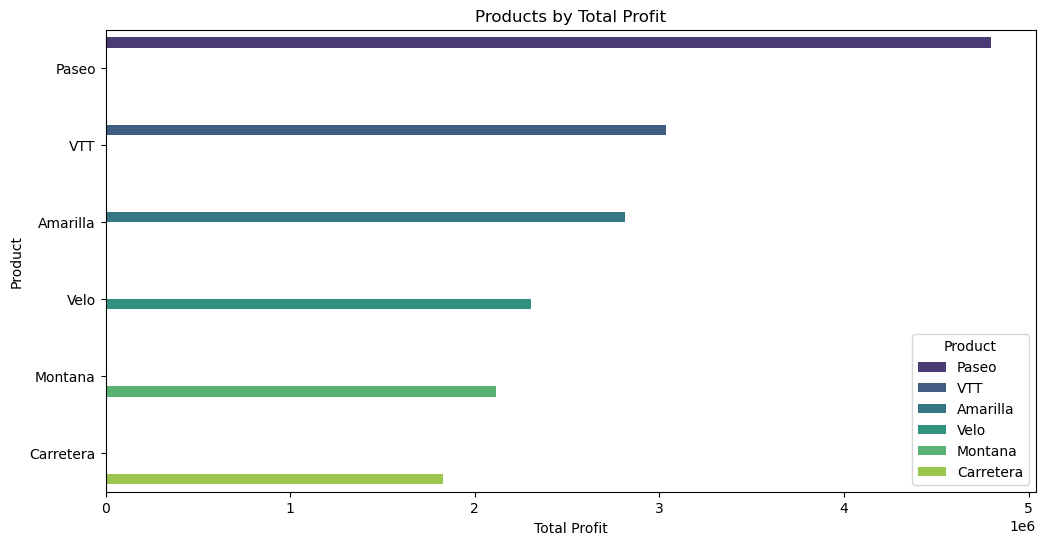

In [20]:
# Group by 'Product' and aggregate 'Sales' and 'Profit'
product_performance = financial_data.groupby('Product').agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()
print(product_performance)

# Identify the product with the highest total sales
highest_sales_product = product_performance.loc[product_performance['Sales'].idxmax()]

# Identify the product with the highest total profit
highest_profit_product = product_performance.loc[product_performance['Profit'].idxmax()]

print("\nProduct with the highest sales:")
print(highest_sales_product)

print("\nProduct with the highest profit:")
print(highest_profit_product)

# Sort the data for better visualisation
sorted_by_sales = product_performance.sort_values('Sales', ascending=False)
sorted_by_profit = product_performance.sort_values('Profit', ascending=False)

# Plotting the products with the highest sales
plt.figure(figsize=(12, 6))
sns.barplot(x='Sales', y='Product', data=sorted_by_sales, palette='cool', hue='Product')
plt.title('Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.show()

# Plotting the products with the highest profit
plt.figure(figsize=(12, 6))
sns.barplot(x='Profit', y='Product', data=sorted_by_profit, palette='viridis', hue='Product')
plt.title('Products by Total Profit')
plt.xlabel('Total Profit')
plt.ylabel('Product')
plt.show()


The product named "Paseo" is the top-performing product in terms of sales and profit within the dataset. It achieved total sales of \$33,000,000 and a profit of \$4,800,000. This indicates that not only is Paseo the most purchased among all the company's products, but this translates directly into high profits, highlighting its significant contribution to both top-line and bottom-line financial performance.

We can break down the data further to analyse and visualise performance by both segment and product.

Product with the highest sales by segment:
             Segment Product        Sales      Profit
3   Channel Partners   Paseo    454514.40   331838.40
9         Enterprise   Paseo   5267860.00   -81740.00
15        Government   Paseo  14882230.71  3057290.71
21         Midmarket   Paseo    907729.35   258739.35
27    Small Business   Paseo  11498809.50  1231309.50

Product with the highest profit by segment:
             Segment  Product        Sales      Profit
3   Channel Partners    Paseo    454514.40   331838.40
8         Enterprise  Montana   2614843.75   -31096.25
15        Government    Paseo  14882230.71  3057290.71
21         Midmarket    Paseo    907729.35   258739.35
27    Small Business    Paseo  11498809.50  1231309.50


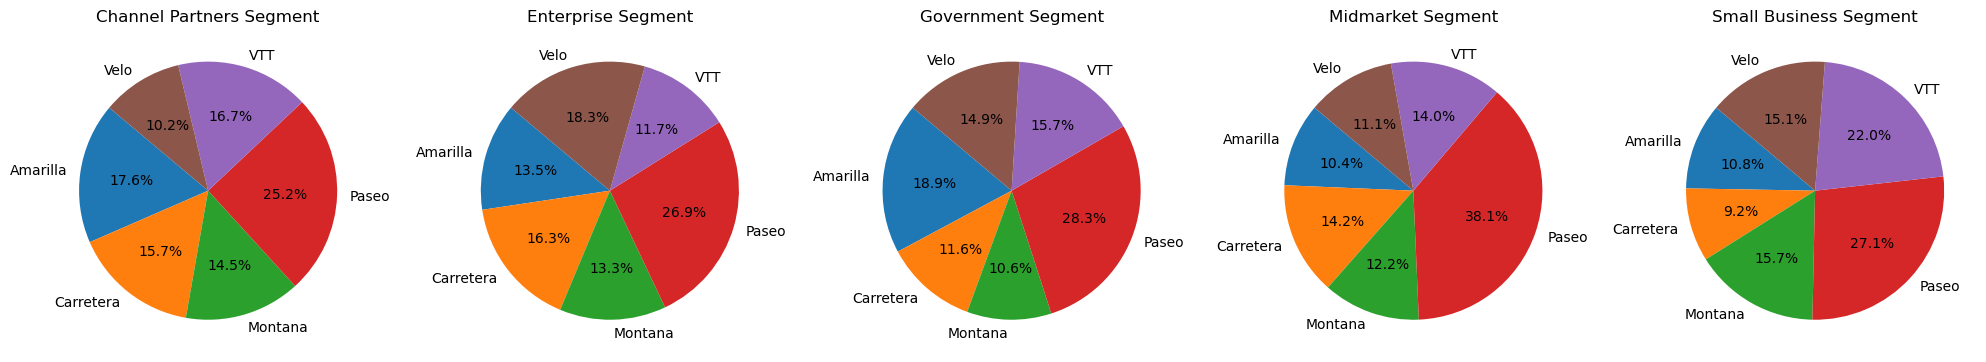

In [21]:
# Group by 'Segment' and 'Product', then aggregate 'Sales' and 'Profit'
segment_product_performance = financial_data.groupby(['Segment', 'Product']).agg({'Sales': 'sum', 'Profit': 'sum'}).reset_index()

# Find the product with the highest sales within each segment
highest_sales_by_segment = segment_product_performance.loc[segment_product_performance.groupby('Segment')['Sales'].idxmax()]

# Find the product with the highest profit within each segment
highest_profit_by_segment = segment_product_performance.loc[segment_product_performance.groupby('Segment')['Profit'].idxmax()]

print("Product with the highest sales by segment:")
print(highest_sales_by_segment)

print("\nProduct with the highest profit by segment:")
print(highest_profit_by_segment)

# Calculate total sales by segment and product
sales_by_segment_product = financial_data.groupby(['Segment', 'Product'])['Sales'].sum().reset_index()

# Get a list of unique segments for iteration
segments = sales_by_segment_product['Segment'].unique()

# Set up the figure for multiple pie charts
fig, axes = plt.subplots(nrows=1, ncols=len(segments), figsize=(20, 6))

# Loop through segments and create a pie chart for each
for i, segment in enumerate(segments):
    # Filter data for the current segment
    segment_data = sales_by_segment_product[sales_by_segment_product['Segment'] == segment]

    # Create pie chart in the corresponding subplot
    axes[i].pie(segment_data['Sales'], labels=segment_data['Product'], autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'{segment} Segment')

plt.tight_layout()
plt.show()


Again, "Paseo" is the product achieving the highest sales across all market segments, emphasising its broad appeal and success, with between 25.2% and 38.1% of total sales. The highest profit by segment analysis reveals a similar pattern, with "Paseo" being the most profitable in all segments except for the Enterprise segment, where "Montana" takes the lead in profitability &ndash; though Enterprise should probably be considered atypical, as every single product was sold for a net loss in this segment. It may be that cost structure is not be optimised in the Enterprise segment, leading to losses there. Alternatively, it could be due to aggressive pricing, high cost of goods sold (COGS), or inefficiencies that need to be addressed.

This summary underscores "Paseo" as a central product in the company's portfolio, demonstrating the highest sales and profitability across almost all segments.

### 3.2.1 Do Discounts affect Sales and Profit?

To answer this question, I start by calculating the overall percentage discounts by market segment from the main dataset (financial_data) and then sort these to highlight the segments with the highest discounts. I visualise this information as a bar chart, which effectively showcases which market segments received the most discounts.

            Segment   Discounts  Gross Sales  Percentage Discounts
0  Channel Partners   134568.36    1935162.0              6.953855
1        Enterprise  1457305.63   21069000.0              6.916824
2        Government  3898805.84   56403066.5              6.912400
3         Midmarket   200786.94    2582670.0              7.774394
4    Small Business  3513781.50   45941700.0              7.648349


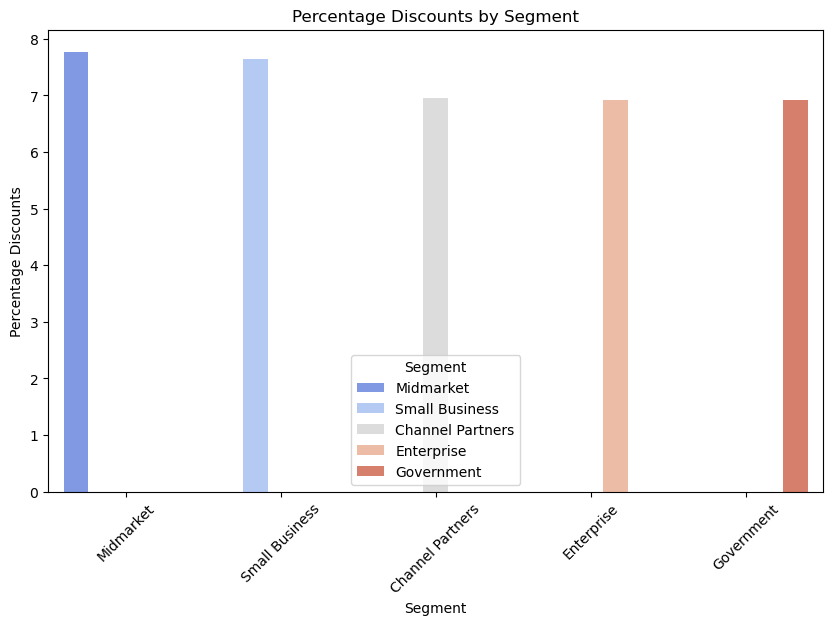

In [22]:
# Aggregate total discounts by segment
discounts_by_segment = financial_data.groupby('Segment').agg({'Discounts': 'sum', 'Gross Sales': 'sum'}).reset_index()
discounts_by_segment['Percentage Discounts'] = discounts_by_segment['Discounts']/discounts_by_segment['Gross Sales']*100
print(discounts_by_segment)
# Sorting the data to have the segment with the highest discounts at the top
#discounts_by_segment_sorted =
discounts_by_segment.sort_values('Percentage Discounts', ascending=False, inplace=True)

# Plotting total discounts by segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Percentage Discounts', data=discounts_by_segment, palette='coolwarm',hue='Segment')
plt.title('Percentage Discounts by Segment')
plt.xlabel('Segment')
plt.ylabel('Percentage Discounts')
plt.xticks(rotation=45)
plt.show()


Overall, there is no significant difference between the levels of discounts offered to the different segments. To look into the question of discount levels further, I create a new column in the database, giving the percentage discount of each transaction. I print a few rows of this expanded database, to get an overview, and summarise the column below.

In [23]:
# Calculate the discount percentage for each row
financial_data['Discount Percentage'] = (financial_data['Discounts'] / financial_data['Gross Sales']) * 100

# Display the DataFrame to verify the new column
print(financial_data[['Segment', 'Gross Sales', 'Discounts', 'Discount Percentage']])

print('\nDiscount Percentage summary:')
print(financial_data['Discount Percentage'].describe())

print('\nPercentage of transactions discounted:')
print(len(financial_data[financial_data['Discount Percentage'] > 0])/7)
#divide by 7 here because there are 700 transactions, *100 for percentage


              Segment  Gross Sales  Discounts  Discount Percentage
0          Government      32370.0       0.00                  0.0
1          Government      26420.0       0.00                  0.0
2           Midmarket      32670.0       0.00                  0.0
3           Midmarket      13320.0       0.00                  0.0
4           Midmarket      37050.0       0.00                  0.0
..                ...          ...        ...                  ...
695    Small Business     742500.0  111375.00                 15.0
696    Small Business     163800.0   24570.00                 15.0
697        Government       9576.0    1436.40                 15.0
698        Government       5061.0     759.15                 15.0
699  Channel Partners      21672.0    3250.80                 15.0

[700 rows x 4 columns]

Discount Percentage summary:
count    700.000000
mean       7.332857
std        4.602271
min        0.000000
25%        3.000001
50%        7.000000
75%       11.000000
ma

The summary shows that discounts are offered at a variety of levels up to 15%. The mean discount offered is 7.33%, with the median very similar at 7%. So, in fact, undiscounted transactions are the exception: 92.4% of transactions received some level of discount! Offering no discount may only be used in scenarios where products are sold with a low margin of negotiation or in government contracts where pricing is tightly controlled. Overall, we see flexibility in pricing strategies to accommodate various sales scenarios and customer negotiations.

Discount levels are grouped, in the dataset, into bands of no, low, medium and high discount. Below, I plot the fraction of transactions in each band, for each product, to gain some insight into how different products are marketed.

<Figure size 1400x800 with 0 Axes>

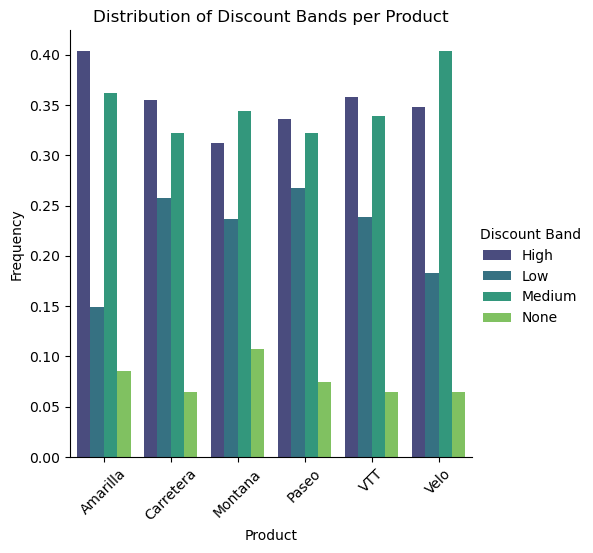

In [24]:
# Count sales in each band by product
discount_bands_by_product = financial_data.groupby(['Product','Discount Band']).agg({'Sales': 'count'}).reset_index()
discount_bands_by_product.rename(columns={'Sales':'Sales count by band and product'}, inplace=True)

# Count sales by product and merge
sales_count_per_product = financial_data.groupby('Product')['Sales'].count().reset_index(name='Sales count by product')
discount_bands_by_product = discount_bands_by_product.merge(sales_count_per_product, on='Product')

# Calculate percentage in each band
discount_bands_by_product['Discount band percentage'] = discount_bands_by_product['Sales count by band and product']/discount_bands_by_product['Sales count by product']

#print(discount_bands_by_product)

# Plot the distribution of discount bands by product
plt.figure(figsize=(14,8))
sns.catplot(data=discount_bands_by_product, kind='bar', x='Product', y='Discount band percentage', hue='Discount Band', palette='viridis')
plt.title('Distribution of Discount Bands per Product')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Overall, we do not see large differences in marketing strategy for different products: high and low discounts are common, with full-price transactions much rarer. The company could consider trying out different pricing strategies for some segments, products or national markets in the future, so that the results can be compared, as a way of further refining their strategy in the future.

## 3.3 Sales data over time

We dig deeper into the sales data by visualising changes over time.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


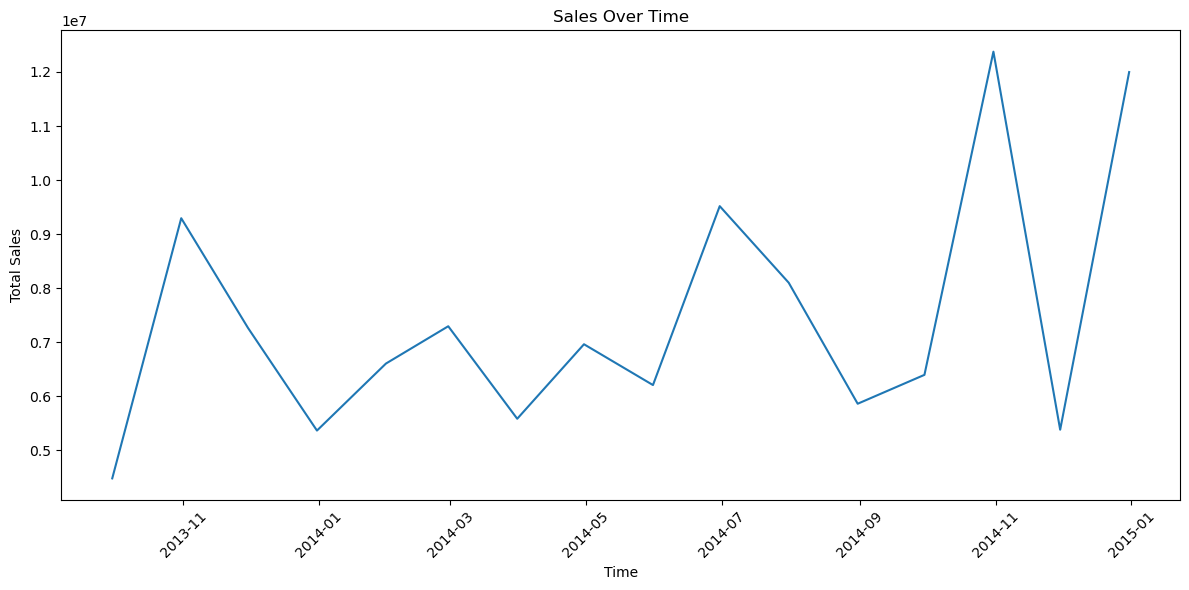

In [25]:
#Visualise the Sales by month time.
monthly_sales = financial_data.resample('M', on='Date')['Sales'].sum().reset_index()

# Plotting sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Date', y='Sales')
plt.title('Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

The period of time covered by this dataset is fairly limited, so it is hard to draw firm conclusions about long-term trends. However, one suggestive point is that sales in November of 2013 and 2014 are very high compared to the surrounding months, so there could be a seasonal trend, possibly related to consumer behavior, such as holiday shopping, or end-of-year budget spending in B2B sectors. The variability in sales figures from month to month highlights the dynamic nature of the market demand. Any opportunity to increase the predictability of sales should be explored, as a way to minimise risk.

I explore the time-dependency of the dataset further in Section 4.


## 3.4 Geographical Distribution

I also want to explore how sales vary by country.

1. How does the total sales volume vary across different countries, and which country has the highest total sales?
2. Which products are most favored in each country according to total sales, and how does product popularity vary across different countries?

To answer these questions I first use the Plotly Express library to create a choropleth map displaying total sales by country, to help visualise geographical variations.

In [26]:
# Print the list of unique countries
print(financial_data['Country'].unique())


['Canada' 'Germany' 'France' 'Mexico' 'United States of America']


In [27]:
total_sales_by_country = financial_data.groupby('Country')['Sales'].sum().reset_index()

# Sort in descending order to see the countries with the highest sales first
total_sales_by_country = total_sales_by_country.sort_values(by='Sales', ascending=False)

# Displaying the resulting DataFrame
print(total_sales_by_country)


                    Country        Sales
4  United States of America  25029830.18
0                    Canada  24887654.89
1                    France  24354172.29
2                   Germany  23505340.82
3                    Mexico  20949352.11


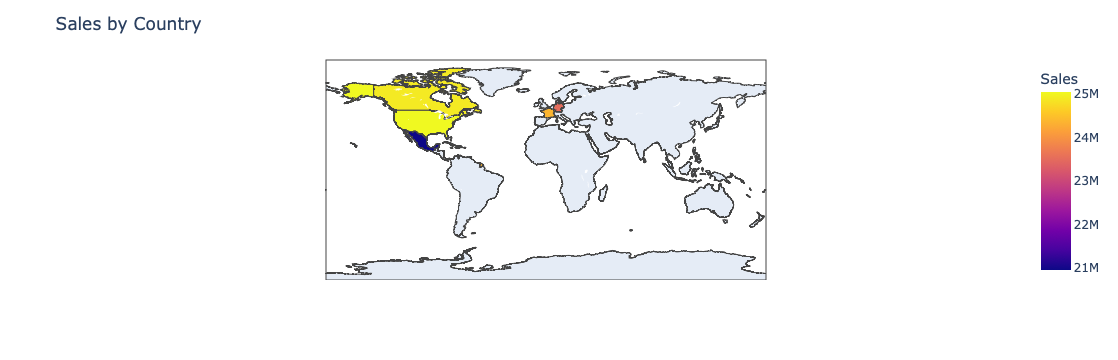

In [28]:
# Plotting the DataFrame
fig = px.choropleth(total_sales_by_country,
                    locations="Country",
                    locationmode='country names',
                    color="Sales",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.update_layout(title='Sales by Country')
fig.show()

The sales to different countries are remarkably similar, varying from \$20,900,000 to \$25,000,000 across the five countries represented in the database. This is very surprising as these numbers are much more similar than, for example, the countries' populations or the sizes of their economies. To fully explain this pattern would probably require further domain knowledge. Conjecturally, there might be a bottleneck on the supply side of the business preventing further growth; if the company felt that total sales over \$20,000,000 were necessary to justify maintaining a presence in each of these countries, but no product were available to sell beyond that point, it could explain the pattern we see.

In the next step, I want to look deeper into the best performing segments of the market, Small Business and Government, as their profitability makes them good targets for growth.

                    Country  Sales to Government
1                    France          12127782.72
2                   Germany          11452895.94
0                    Canada          10741236.52
3                    Mexico           9791599.38
4  United States of America           8390746.12


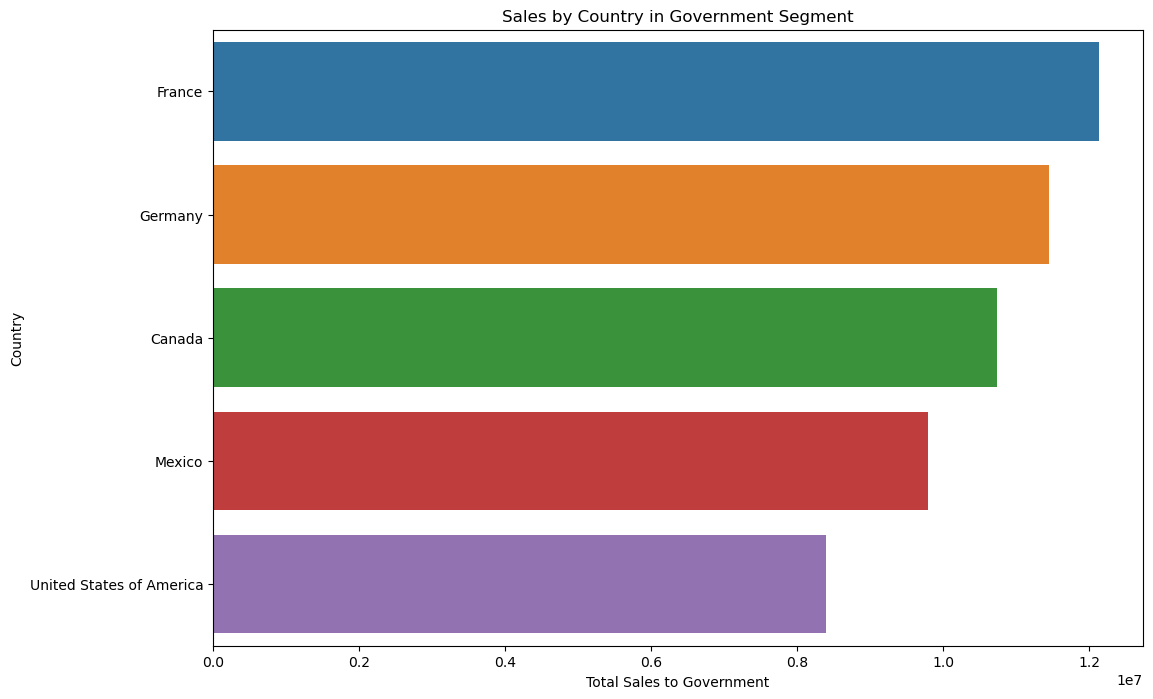

In [29]:
# Geographical Influence on Government sales
geo_influence = financial_data[financial_data['Segment'] == 'Government'].groupby('Country').agg({'Sales': 'sum'}).reset_index()
geo_influence.sort_values('Sales', ascending=False, inplace=True)
geo_influence.rename(columns={'Sales':'Sales to Government'}, inplace=True)
print(geo_influence)

# Visualize sales by country in the Government segment
plt.figure(figsize=(12, 8))
sns.barplot(y='Country', x='Sales to Government', data=geo_influence)
plt.title('Sales by Country in Government Segment')
plt.xlabel('Total Sales to Government')
plt.ylabel('Country')
plt.show()

                    Country  Sales to Small Business
4  United States of America               11456559.0
0                    Canada                9177549.0
1                    France                7369606.5
2                   Germany                7327848.0
3                    Mexico                7096356.0


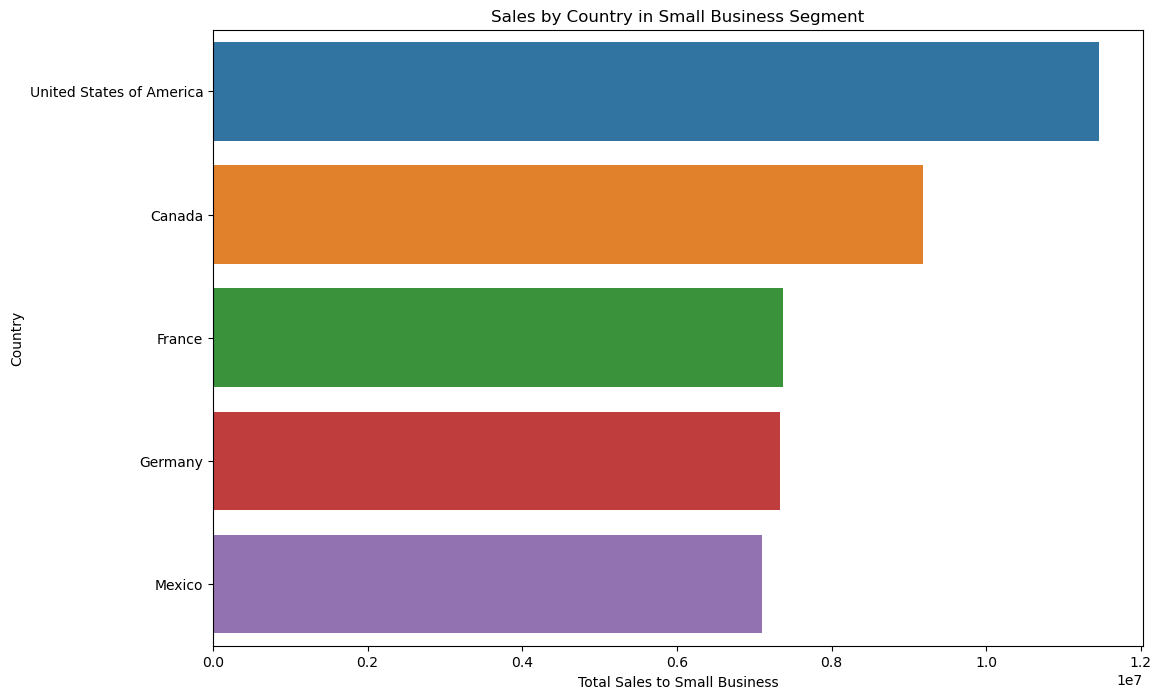

In [30]:
# Geographical Influenceon Small Business sales
country_influence = financial_data[financial_data['Segment'] == 'Small Business'].groupby('Country').agg({'Sales': 'sum'}).reset_index()
country_influence.sort_values('Sales', ascending=False, inplace=True)
country_influence.rename(columns={'Sales':'Sales to Small Business'}, inplace=True)
print(country_influence)

# Visualize sales by country in the Small Business segment
plt.figure(figsize=(12, 8))
sns.barplot(y='Country', x='Sales to Small Business', data=country_influence)
plt.title('Sales by Country in Small Business Segment')
plt.xlabel('Total Sales to Small Business')
plt.ylabel('Country')
plt.show()


In the Government segment, France leads in sales with \$12,100,000, followed by Germany, Canada, Mexico, and the United States of America, with the latter showing the lowest sales at \$8,400,000.

Conversely, in the Small Business segment, the United States of America tops the list with \$11,500,000, indicating a stronger performance compared to its standing in the Government segment. Following the USA are Canada, France, Germany, and Mexico, with Mexico having the lowest sales in this segment at \$7,100,000.

This comparison highlights the varying performance of countries across different market segments, with the USA showing a notable reversal in ranking when moving from the Government to the Small Business segment. It could be that, in this market, the USA is skewed more towards the private sector relative to the other countries in the dataset, reflecting a more free-market approach.

## 4. In-depth Analysis <a name="deda"></a>

Following our exploratory data analysis (EDA), we explore further the trends in sales and profits over time across various segments. This detailed investigation offers further insights into how different segments perform, shedding light on their dynamics and contributions to overall success.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



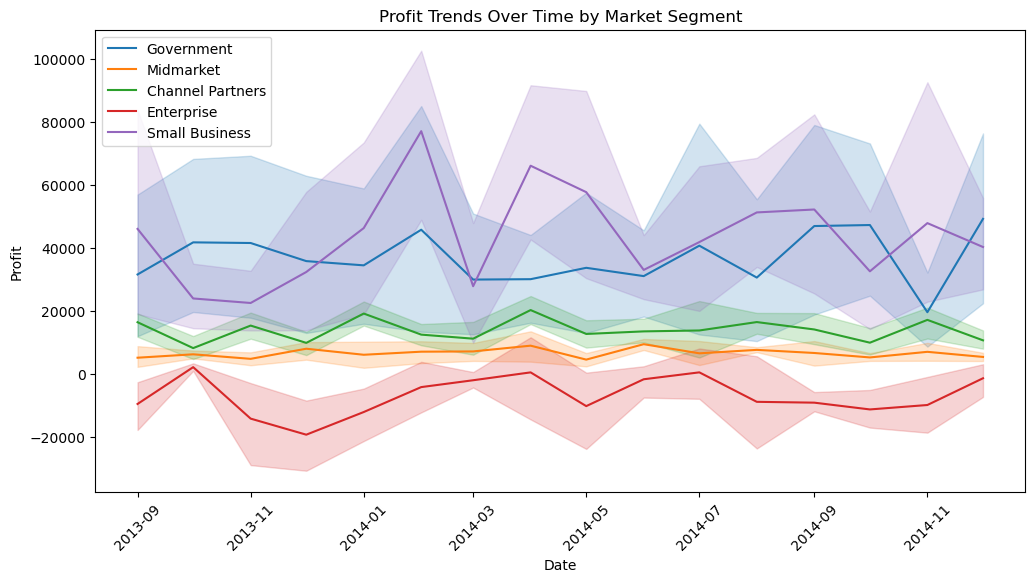

In [31]:
# Line plot for profit trends over time in each market segment
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Profit', hue='Segment', data=financial_data)
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit Trends Over Time by Market Segment')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

This largely agrees with my earlier analysis that Small Business and Government are highly profitable segments for this company, while Enterprise tends to make a loss. Over the time period covered by the dataset, the trends are quite flat; a longer time series would be helpful for this analysis.

Notably, the profit from Small Business fluctuates much more than from the other segments, suggesting a more dynamic market. It also looks visually like the Government segment is the second most variable. So it seems that less predictable segments are associated with higher profits, perhaps because increased prices are needed to compensate for the increased temporal risk.

Doing smaller amounts of trade with the more stable market segments like Channel Partners and Midmarket, on this analysis, could be an attempt by the company to manage their risk profile through diversification.

### How do sales figures compare when discounts are applied versus when no discounts are offered?

To address this question I sum up the sales data by time and by discount level, to understand the impact of discounts on sales over time. This approach allows for an analysis of how discount strategies correlate with sales performance across different periods.

In [32]:
monthly_sales_by_discount = financial_data.groupby(['Date', 'Discount Band'])['Sales'].sum().reset_index()

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



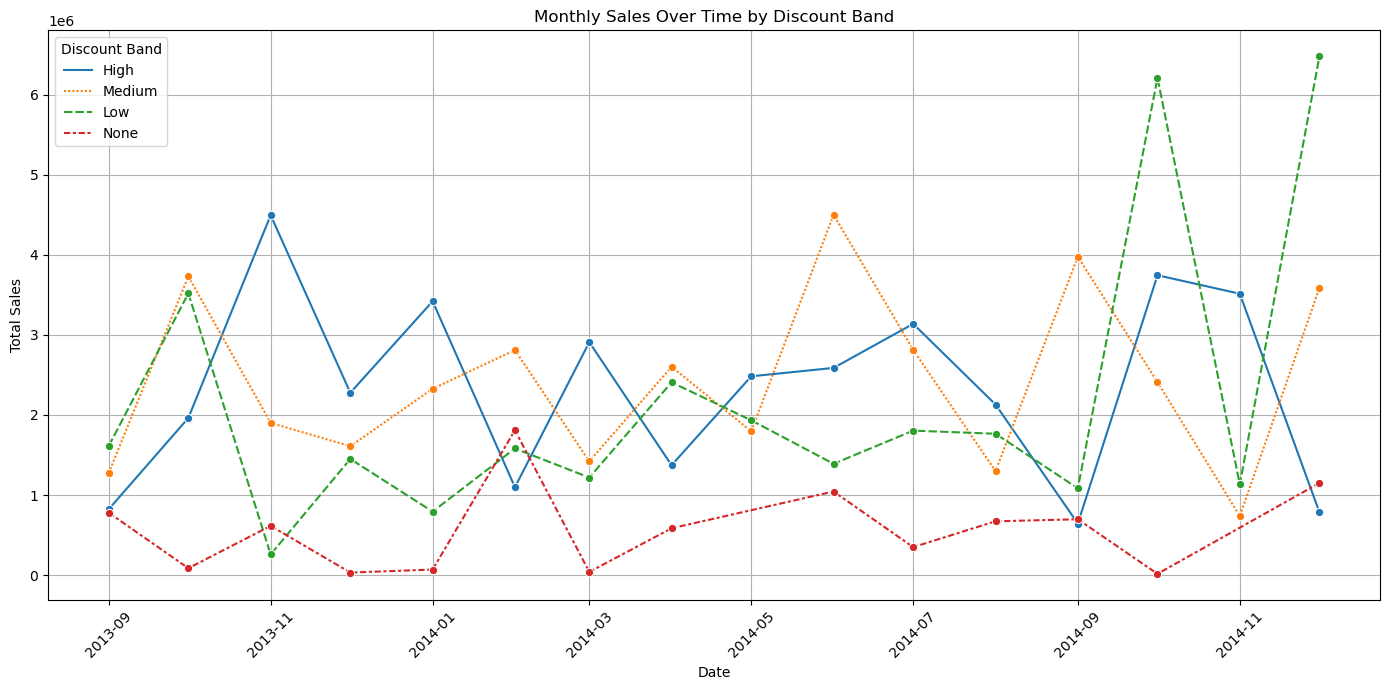

In [33]:
plt.figure(figsize=(14, 7))

# Plotting with corrected DataFrame name and columns
hue_order=['High','Medium','Low','None']
sns.lineplot(data=monthly_sales_by_discount, x='Date', y='Sales', hue='Discount Band', marker='o', style='Discount Band', hue_order=hue_order)

plt.title('Monthly Sales Over Time by Discount Band')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45) # improve readability of x-axis labels
plt.legend(title='Discount Band')
plt.grid(True)

plt.tight_layout()
plt.show()


Earlier in the time period covered by the dataset, we see the highest sales for transactions with high or medium discounts, which would support the hypothesis that higher discounts encourage sales. In October and December 2014, there is a large spike in sales with low discounts, which argues against this idea; however, given the small number of data points involved, this could simply be an anomaly, caused by a few very large transactions with a low discount.

An alternative would be if the company changed their pricing strategy at this time, changing how and when the various discount levels were offered. Analysing this possibility, and distinguishing between these two theories, would require further information from the company.

## 5. Predictive Modeling and Forecasting: <a name="predict"></a>

I would like to build a model that can predict total sales over time, to inform the company's future strategy. Here I consider two model: first a simple linear regression model, then a more complex random forest regression model.

### Predicting Sales using LinearRegression


I first predict sales using a linear regression model with dates converted to ordinal format. This method simplifies the relationship between time and sales into a linear format that can be understood by the model. I split the data into Sales up to September 2014, which will be the training set, and Saes from October 2014 onwards, which will be the testing set.

The model's performance is evaluated using standard metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and the Coefficient of Determination (R² score). These metrics collectively assess the model's accuracy and predictive power, indicating its potential utility in forecasting sales based on historical data and associated features.

In [34]:
# Convert 'Date' to a numerical format (ordinal) before splitting
financial_data['Date_ordinal'] = financial_data['Date'].map(datetime.toordinal)

# Train on data before October 2014; test the model on data after this
train_data = financial_data[financial_data['Date'] <= datetime(2014,9,1)]
test_data = financial_data[financial_data['Date'] > datetime(2014,9,1)]

# X should be 2D so we use .values.reshape(-1, 1)
X_train = train_data['Date_ordinal'].values.reshape(-1, 1)
y_train = train_data['Sales']
X_test = test_data['Date_ordinal'].values.reshape(-1, 1)
y_test = test_data['Sales']

# Initialise and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Coefficient of Determination (R² score): {r2}')

Mean Absolute Error (MAE): 190458.49267689182
Mean Squared Error (MSE): 54581701454.13455
Coefficient of Determination (R² score): -0.009330498025162282


/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



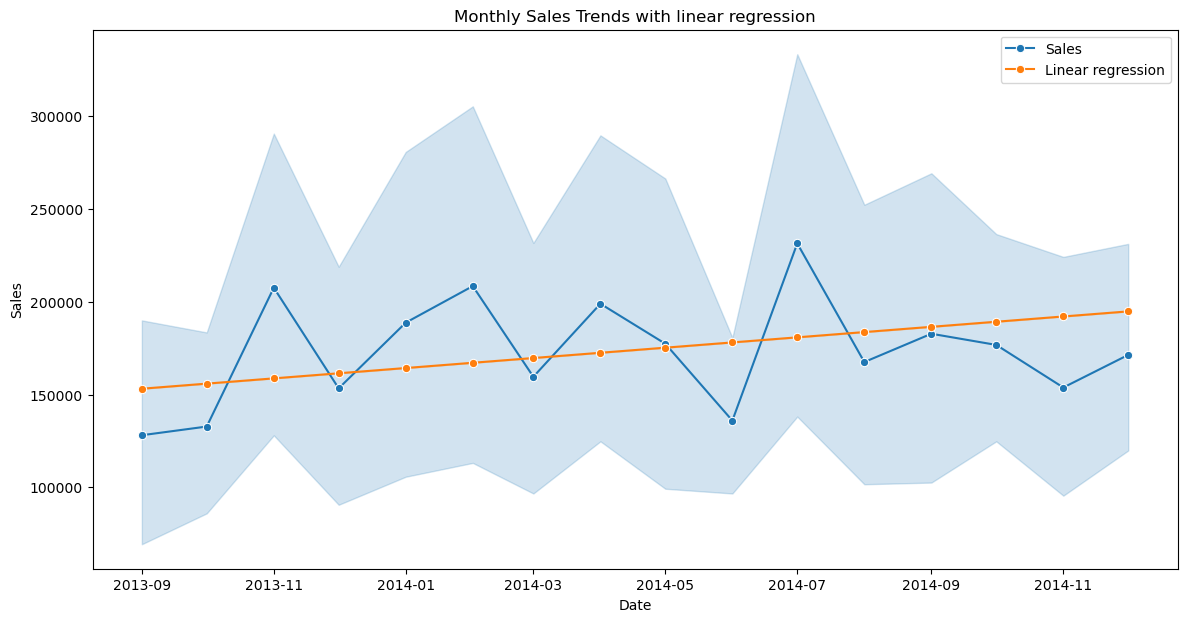

In [35]:
# Draw a graph with the best fit line up to September 2014
financial_data['Predicted Sales'] = model.predict(financial_data['Date_ordinal'].values.reshape(-1,1))

plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Sales', data=financial_data, marker='o', label='Sales')
sns.lineplot(x='Date', y='Predicted Sales', data=financial_data, marker='o', label='Linear regression')
plt.title('Monthly Sales Trends with linear regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

This graph shows the best fit line which minimises the mean squared error up to September 2014. The last three months of data form the testing set. The model predicts a gradual increase in sales over the period of the dataset, but the graph shows it is not a good fit for the testing set, where sales stay at a similar level to their value in September 2014. MSE is 54,600,000,000, and the coefficient of determination gives a negative R² score of -0.0093, that is, the total Sales over time up to September 2014 has negative predictive value for the variation in Sales after that. This could be seen as an example of anti-inductive market behaviour, in which (in an efficient market) any predictable change over time is already accounted for by the market and therefore future behaviour becomes unpredictable; however, in this case, it is more likely just that a linear model is too simple to capture the complexities of changes in Sales.

I try a more complex model next, to try and make more meaningful predictions.

### Predicting Sales using RandomForestRegressor

I train Sklearn's RandomForestRegressor model to predict sales, using both numerical (Date and Sale Price) and categorical (Segment, Country, Product and Discount Band) features of the data. The RandomForestRegressor is known for its robustness and ability to handle complex datasets. Firstly, I make sure all the categorical data is changed into a format that the computer can easily work with. This helps my model understand and use the data better. The model is trained, once again, on the data up to September 2014, and then used to predict Sales for October onwards.


In [36]:
# Select features and target variable
X_train = train_data
X_test = test_data

# Preprocessing for numerical and categorical data
numeric_features = ['Date_ordinal', 'Sale Price']

categorical_features = ['Segment', 'Country', 'Product', 'Discount Band']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features), #numeric_transformer
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Coefficient of Determination (R² score): {r2}')


Mean Absolute Error (MAE): 79321.27687542858
Mean Squared Error (MSE): 23109782744.890366
Coefficient of Determination (R² score): 0.5726514948099588


/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/ellienccook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



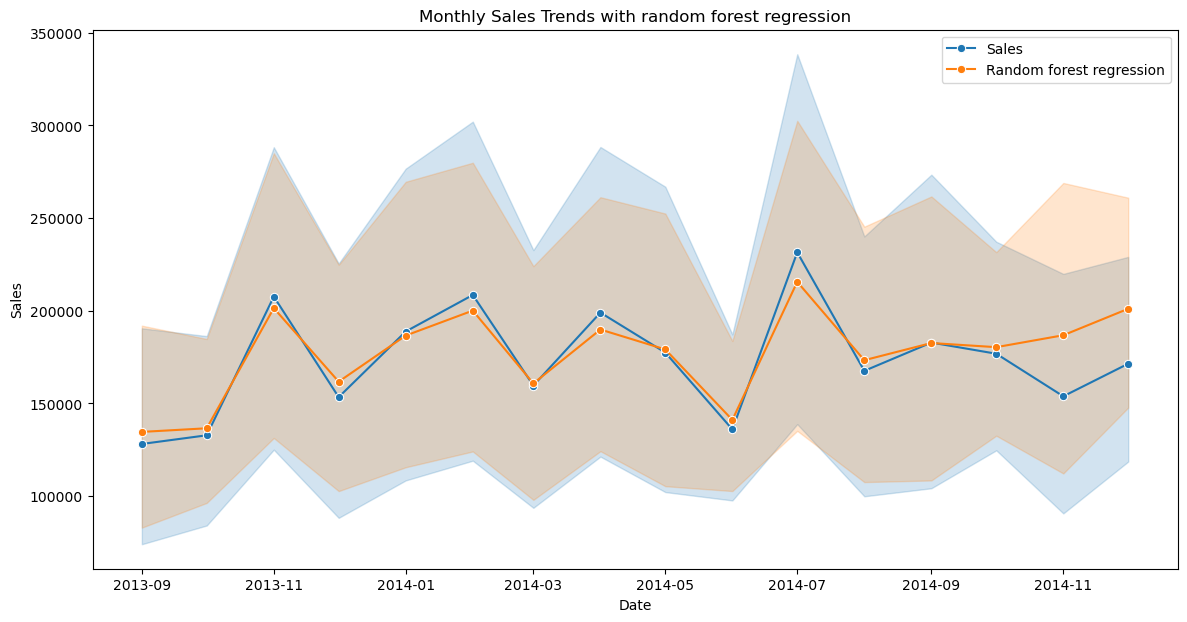

In [37]:
# Draw a graph with the regression line predicted by data up to September 2014
financial_data['Predicted Sales'] = pipeline.predict(financial_data)

plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Sales', data=financial_data, marker='o', label='Sales')
sns.lineplot(x='Date', y='Predicted Sales', data=financial_data, marker='o', label='Random forest regression')
plt.title('Monthly Sales Trends with random forest regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

For this model, we see a significant improvement in the MSE, from 54,600,000,000 to 23,000,000,000, and a highly significant improvement in the R² score, from -0.0093 to +0.57, meaning that this model can account for over half of the variance in Sales in the testing data. These gains indicate that the random forest regression model performs much better than the linear regression model at predicting future Sales, and is now a very useful forecasting tool for the company.

Overall, the random forest model is able to give accurate big-picture predictions of likely future movements in Sales, and could be applied to predict other metrics too, like profitability, as well as for specific market segments, products, and countries.

## 6. Ethics <a name="ethics"></a>

Considering the ethical considerations in sales and profit optimization projects, especially those involving pricing strategies, demand forecasting, and cost management, is crucial. There are several important issues to consider. For the current project, most of these will only need to be addressed if and when the company chooses to use our analysis to adjust its pricing strategy, but I include these points now so that they are properly considered at the outset of any such process.

**Fair Pricing**
We must make sure that pricing strategies do not exploit customers, especially in markets with limited competition, or for essential products and services. Price optimisation should avoid practices that could be considered price gouging. This also avoids negative impact to the company's reputation.

**Data Privacy and Security**
When using customer data for modeling and analysis, the company must comply with data protection regulations such as GDPR in Europe. We must securely handle and store data, ensuring that customer information is not misused or exposed to unauthorised parties.

In the case of the current dataset, our use of it is permitted by the Database Contents License (DbCL) v1.0 (see [2]), under which Kaggle provides the data.

**Transparency**
The company should be transparent about how data is used in profit optimisation models. When appropriate, they should inform customers about how their data contributes to pricing or product offerings, which will help to maintain a positive relationship with customers.

**Access and Equity**
The company must consider the impact of pricing decisions on access to products and services, especially for vulnerable or marginalised groups. Strategies should not create or exacerbate inequalities or barriers to access. This may also be necessary to comply with legal equality regulations for protected groups.

We should alway keep these ethical consideration in mind when adjusting our approach to pricing. In this way, businesses can ensure their profit optimisation efforts are responsible, sustainable, and pro-social, thereby protecting their reputation and building long-term customer loyalty.

## 7. Conclusions <a name="conclude"></a>

This project uses a wide variety of tools to explore the data, give us a deep understanding of the market, and inform a strategy to increase Sales and Profit and create a win-win scenario for the company and their customers. We can briefly sum up the most important points.

**Review Pricing and Costs in the Enterprise Segment**
The negative profit associated with high sales in the Enterprise segment suggests a need to review the pricing strategy or cost structure in this segment. Analysing the direct and indirect costs, and possibly adjusting the pricing accordingly, could mitigate losses.

**Leverage the Success of Paseo**
Given Paseo's success in multiple segments, strategies to further leverage this product's market position should be considered. This could include marketing initiatives, sales incentives, or exploring cross-selling opportunities with other products.

**Product Portfolio Analysis**
The dominance of Paseo suggests it is a cornerstone product, but this dominance leaves the company vulnerable to future changes. Diversifying the product portfolio and ensuring other products are also positioned for success could mitigate these risks.

**Segmentation Strategy**
Focusing on Small Business and Government segments could be highly beneficial for maximising profit, provided that the inherent variability in deal size and profitability within these segments is managed effectively. The Midmarket and Channel Partners segments represent stable revenue streams with consistent profit margins, which are essential for overall business stability.

**Evaluating Discount Impact**
Understanding the impact of these discounting strategies on profitability, customer acquisition, and retention is essential. The company should consider trialling different strategies in different markets, segments or products, to assess whether the current discounts are driving the desired behaviors and outcomes. There may be opportunities to optimise discount levels based on the elasticity of demand in each segment. For example, if a lower discount in the Enterprise segment doesn't significantly impact sales volumes, maintaining lower discounts could improve margins.

**Future Outlook**
Based on my model's accuracy and predictive performance, I would leverage this model for sales forecasting and decision-making processes. The insights provided by the model can help optimise pricing strategies, allocate resources efficiently, and make informed business decisions to maximise profitability. While the model demonstrates strong performance, it is essential to continuously monitor its performance and retrain it periodically with new data to ensure its relevance and effectiveness over time. Deploying this model in the company's sales forecasting processes can lead to more informed and data-driven decisions, ultimately driving improved business outcomes and profitability.

## 8. References <a name="refer"></a>
1. Dataset: Company Financials Dataset by ATHARVA ARYA https://www.kaggle.com/datasets/atharvaarya25/financials/data
2. Database Contents License (DbCL) v1.0: https://opendatacommons.org/licenses/dbcl/1-0/